The University of Melbourne, School of Computing and Information Systems

# COMP30027 Machine Learning, 2024 Semester 1
## Project 2: IMDB Movie Rating Prediction

The goal of this project is to build and critically analyze supervised machine learning methods for predicting IMDB movie ratings based on various predictor variables that include movie-title, duration, director and actor(s) names and facebook likes, keywords, genre, country, budget, and others. There are five possible outcomes 0 being the lowest and 4 being the highest.

This assignment aims to reinforce the largely theoretical lecture concepts surrounding data representation, classifier construction, evaluation and error analysis, by applying them to an open-ended problem. You will also have an opportunity to practice your general problem-solving skills, written communication skills, and critical thinking skills

# Imports


In [488]:
import pandas as pd
import numpy as np
from collections import Counter
from tqdm import tqdm

# stop words
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# general
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, LabelEncoder, FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import TruncatedSVD
from sklearn.utils import resample
from sklearn.ensemble import VotingClassifier
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from scipy.sparse import csr_matrix

# classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression, LogisticRegression

# visualisation
import seaborn as sns
from sklearn import tree
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jason\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Read data into Dataframes


In [490]:
# Read training and testing dataset into dataframes
train_df = pd.read_csv("project_data/train_dataset.csv")
test_df = pd.read_csv("project_data/test_dataset.csv")

original_columns = list(train_df.columns)
original_numerical = train_df.select_dtypes(include=['int', 'float']).columns

# Feature Engineering 

In [491]:
# Load the features from the .npy files
train_doc2vec_features_plot_keywords = np.load('project_data/features_doc2vec/train_doc2vec_features_plot_keywords.npy')
train_doc2vec_features_genre = np.load('project_data/features_doc2vec/train_doc2vec_features_genre.npy')

test_doc2vec_features_plot_keywords = np.load('project_data/features_doc2vec/test_doc2vec_features_plot_keywords.npy')
test_doc2vec_features_genre = np.load('project_data/features_doc2vec/test_doc2vec_features_genre.npy')

# Convert features to strings and assign them to DataFrame columns
train_df['plot_keywords'] = [str(feature) for feature in train_doc2vec_features_plot_keywords]
train_df['genres'] = [str(feature) for feature in train_doc2vec_features_genre]

test_df['plot_keywords'] = [str(feature) for feature in test_doc2vec_features_plot_keywords]
test_df['genres'] = [str(feature) for feature in test_doc2vec_features_genre]


# Display the updated DataFrame
display(train_df.head(3))

,id,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,title_year,actor_2_facebook_likes,movie_facebook_likes,title_embedding,average_degree_centrality,imdb_score_binned
0,1,Roger Allers,186,73,28,847,Nathan Lane,2000,422783777,[ 3.07836081e-03 -1.64460740e-03 9.62910999e-...,...,656,English,USA,G,1994,886,17000,[-4.1984697e-03 4.2941985e-03 -1.1961063e-03 ...,0.001576,4
1,2,George A. Romero,252,97,0,233,Shawn Roberts,654,20433940,[ 1.7510699e-03 1.0498457e-03 4.6066162e-03 ...,...,662,English,Canada,R,2005,529,0,[-4.7586653e-03 2.6511205e-03 -3.7954253e-04 ...,0.000675,2
2,3,David Gordon Green,232,117,234,221,Tye Sheridan,12000,371897,[-3.02969874e-03 -3.05648567e-03 -3.52535793e-...,...,118,English,USA,R,2013,1000,11000,[ 2.78131524e-03 -3.15494463e-03 -6.38332494e-...,0.003002,2


In [492]:
# Separate features and class for training df
train_df = train_df.dropna(how='any') # drop rows with any missing values

X = train_df.drop(columns=["imdb_score_binned"])         
y = train_df["imdb_score_binned"]

# Test dataset only contains features without labels 
X_test = test_df

In [493]:
# Define features 
numeric_features = list(X.select_dtypes(include=['int64', 'float64', 'float32']).columns)
name_features = ['director_name', 'actor_2_name', 'actor_1_name', 'actor_3_name']
categorical_features = [col for col in X.select_dtypes(include=['object']).columns if col not in name_features]

print(numeric_features)
print(categorical_features)
print(name_features)

['id', 'num_critic_for_reviews', 'duration', 'director_facebook_likes', 'actor_3_facebook_likes', 'actor_1_facebook_likes', 'gross', 'num_voted_users', 'cast_total_facebook_likes', 'facenumber_in_poster', 'num_user_for_reviews', 'title_year', 'actor_2_facebook_likes', 'movie_facebook_likes', 'average_degree_centrality']
['genres', 'movie_title', 'plot_keywords', 'language', 'country', 'content_rating', 'title_embedding']
['director_name', 'actor_2_name', 'actor_1_name', 'actor_3_name']


# Explore Data

In [494]:
print('*'*60)
print("Shape of dataset : ",X.shape)
print('*'*60)
print("NUMERICAL DATA ANALYSIS")
print('*'*60)
print(X.describe().T)
print('*'*60)
print("CATEGORICAL DATA ANALYSIS")
print('*'*60)
print(X.describe(exclude = ['float', 'int64']).T)
print('*'*60)
print("MISSING VALUES")
print('*'*60)
print(X.isnull().sum())
print('*'*60)

************************************************************
Shape of dataset :  (3003, 26)
************************************************************
NUMERICAL DATA ANALYSIS
************************************************************
                            count          mean           std        min  \
id                         3003.0  1.502072e+03  8.671514e+02     1.0000   
num_critic_for_reviews     3003.0  1.656260e+02  1.212712e+02     2.0000   
duration                   3003.0  1.100793e+02  2.191376e+01    37.0000   
director_facebook_likes    3003.0  7.790396e+02  2.991229e+03     0.0000   
actor_3_facebook_likes     3003.0  7.681159e+02  1.902256e+03     0.0000   
actor_1_facebook_likes     3003.0  7.657469e+03  1.649092e+04     0.0000   
gross                      3003.0  5.189374e+07  6.840704e+07   162.0000   
num_voted_users            3003.0  1.049292e+05  1.508749e+05    91.0000   
cast_total_facebook_likes  3003.0  1.139542e+04  2.004699e+04     0.0000   
fa

# Visualise Data

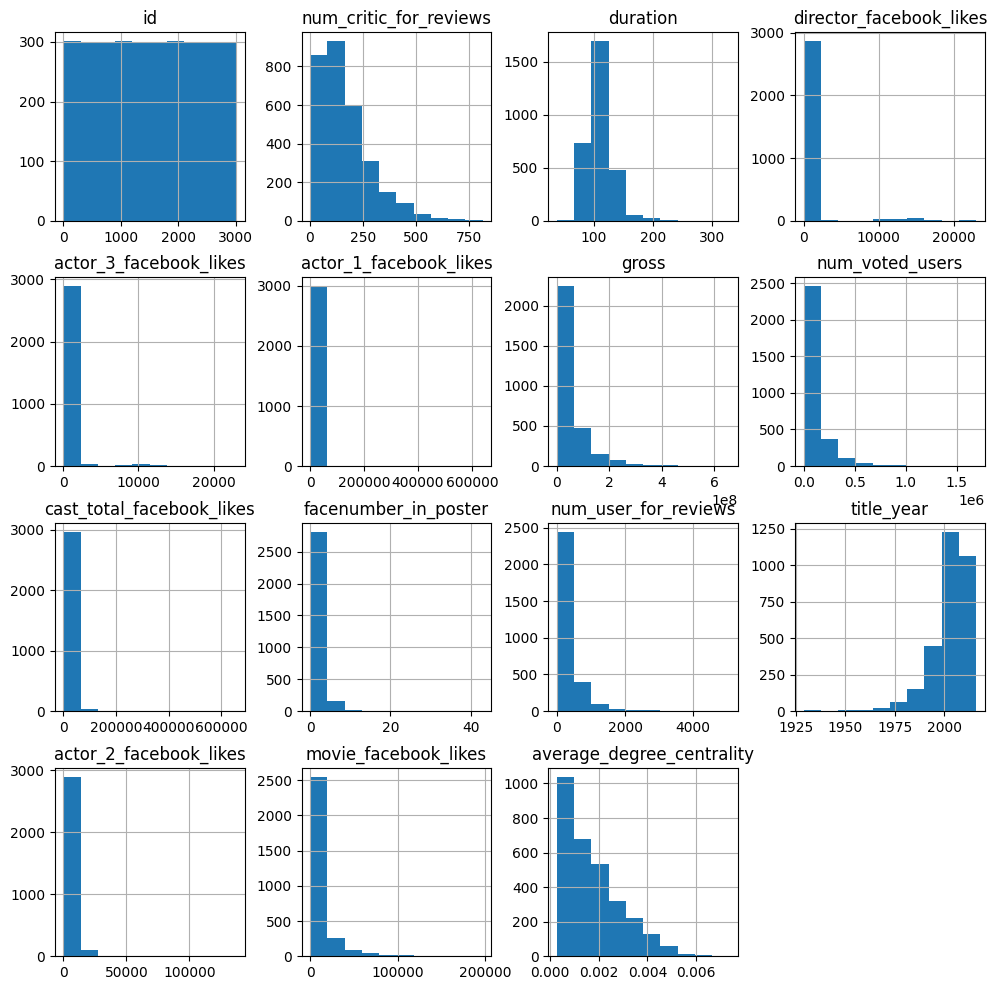

In [424]:
histograms = X[original_columns[:-1]].hist(figsize = [12, 12])
plt.savefig('histograms.png')

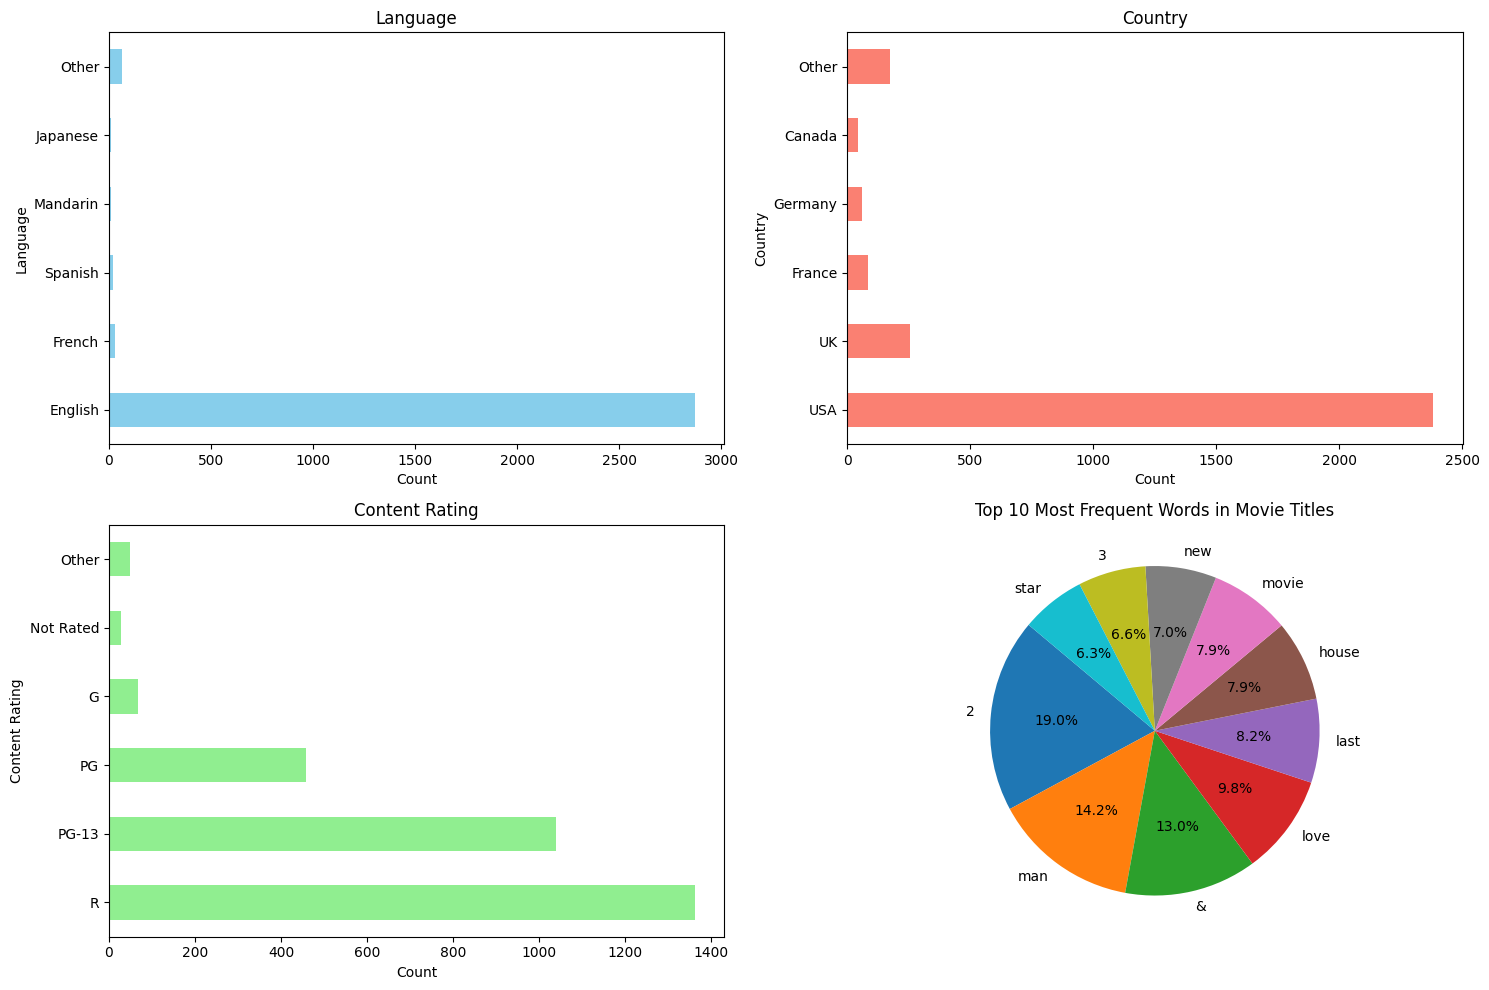

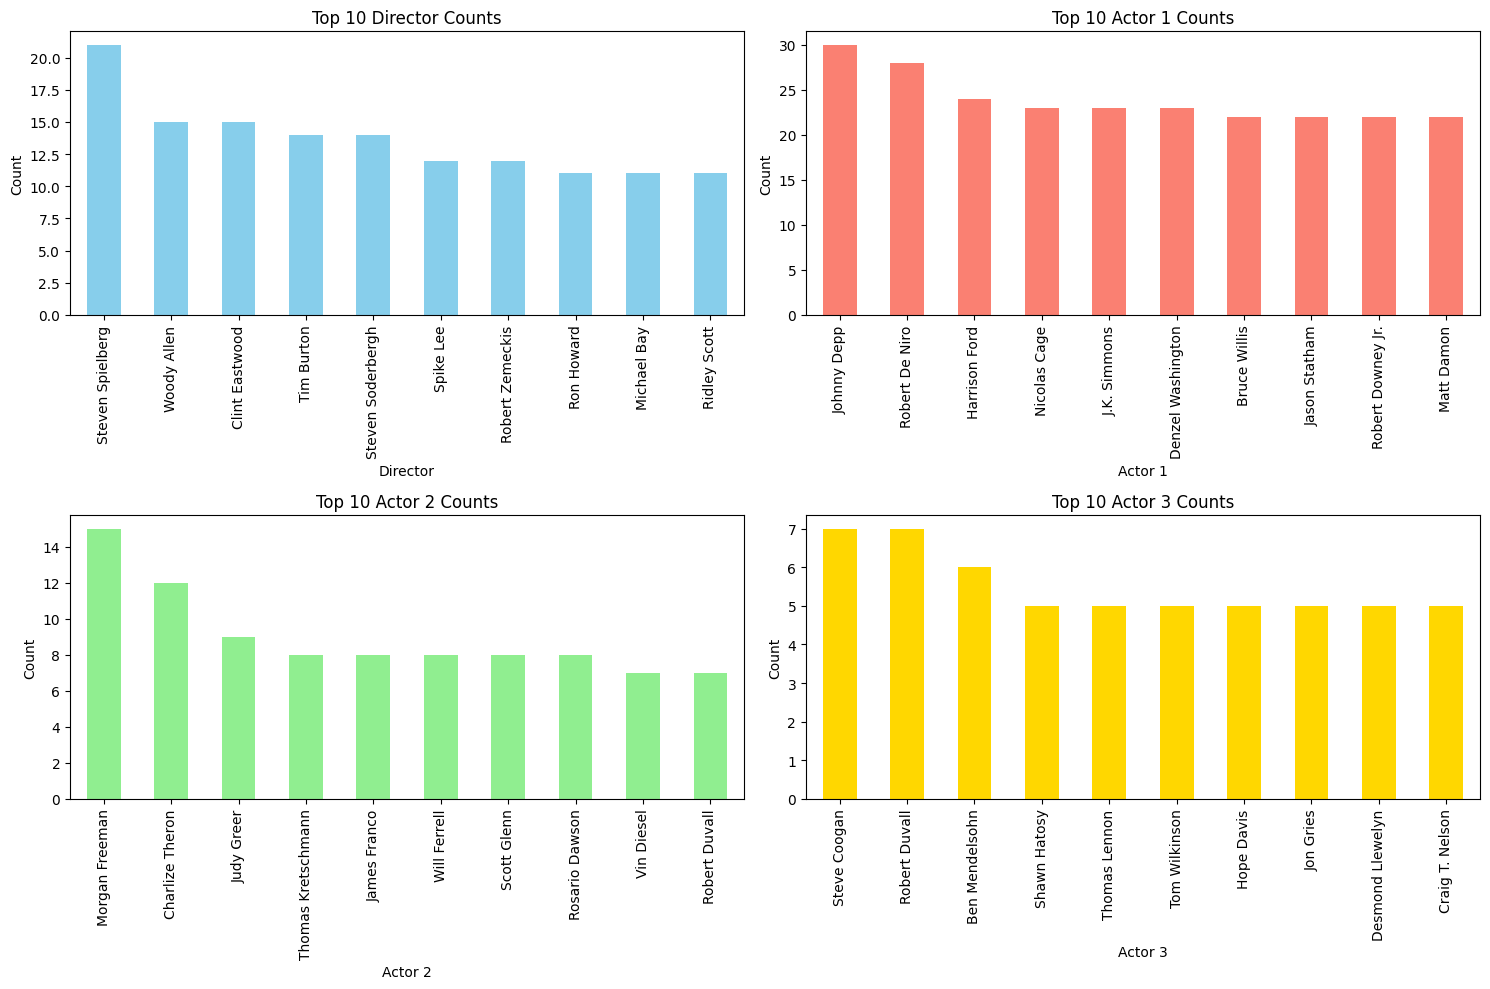

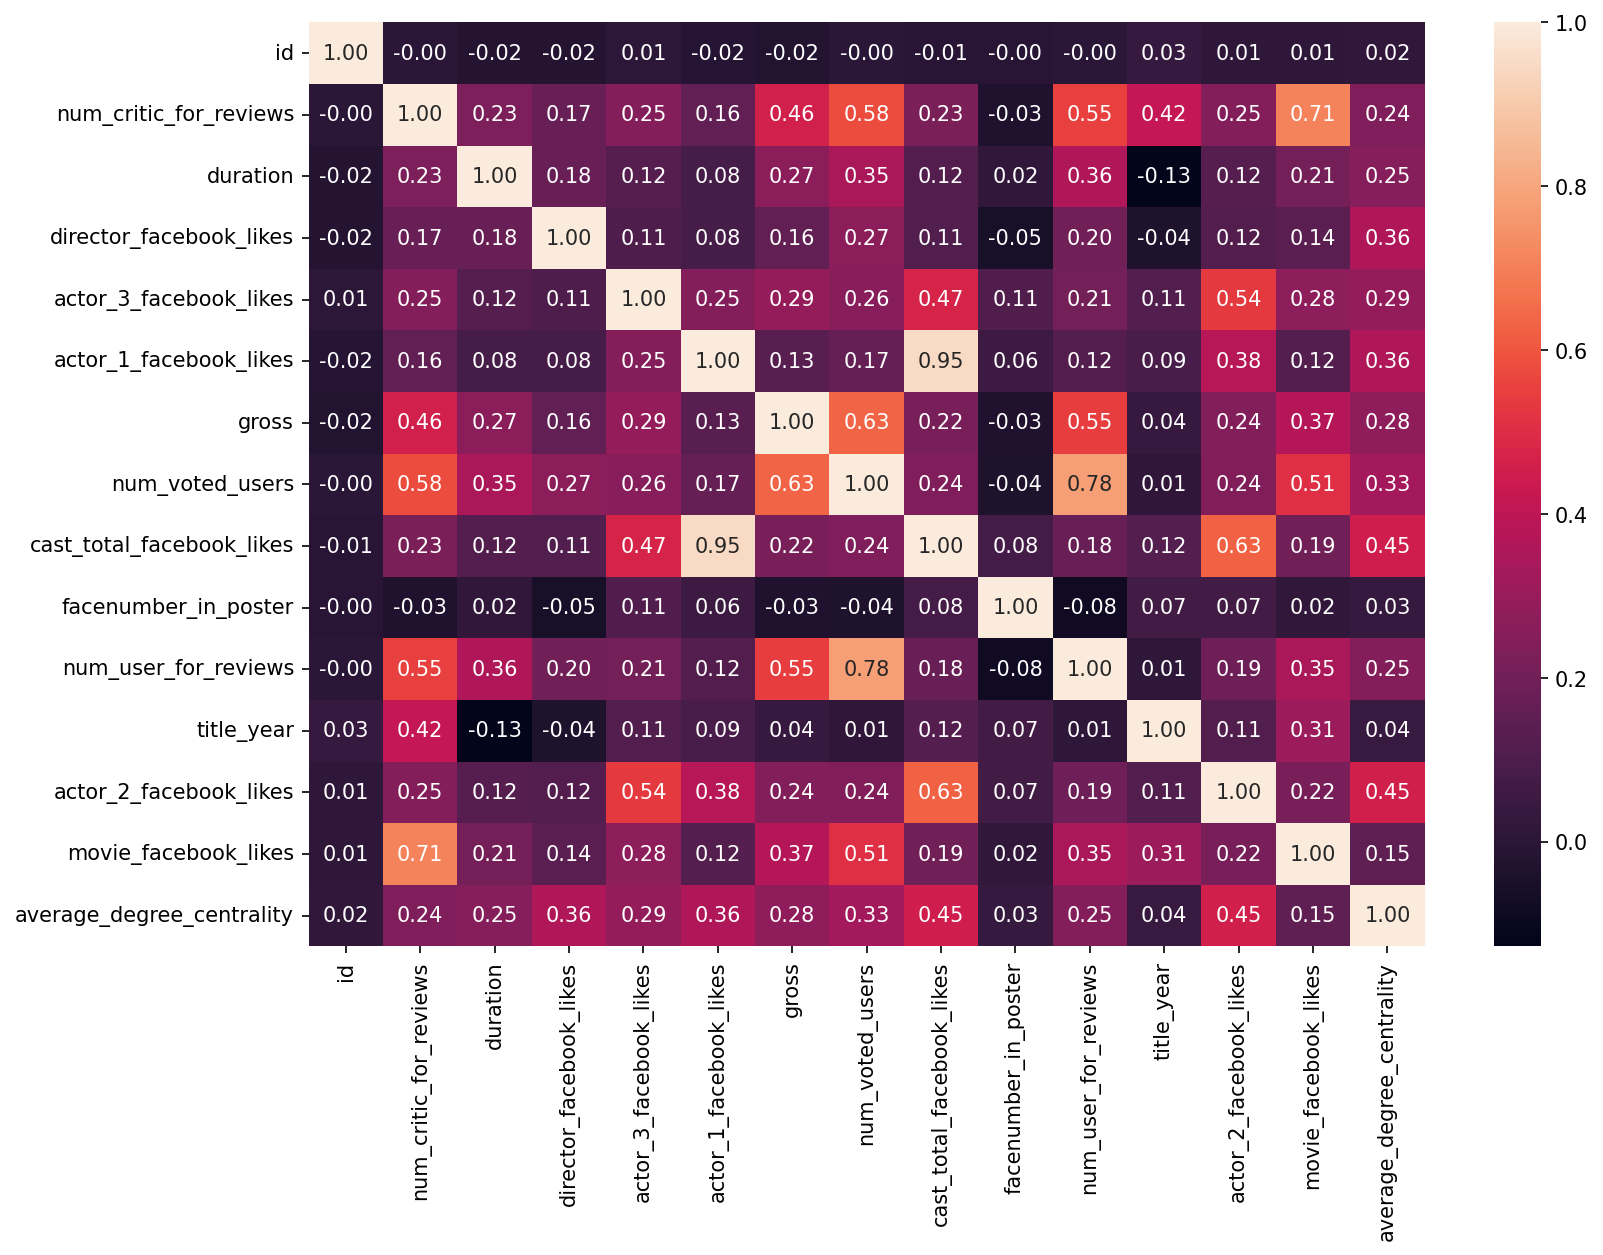

In [425]:
#Plotting the categorical variables on the target
plot_data = True

if plot_data:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Plot horizontal bar plot for language
    language_counts = X['language'].value_counts()
    top_languages = language_counts[:5]  # Display only the top 5 languages
    other_languages_count = language_counts[5:].sum()
    top_languages['Other'] = other_languages_count
    top_languages.plot(kind='barh', ax=axes[0, 0], color='skyblue')
    axes[0, 0].set_title('Language')
    axes[0, 0].set_ylabel('Language')
    axes[0, 0].set_xlabel('Count')

    # Plot horizontal bar plot for country
    country_counts = X['country'].value_counts()
    top_countries = country_counts[:5]  # Display only the top 5 countries
    other_countries_count = country_counts[5:].sum()
    top_countries['Other'] = other_countries_count
    top_countries.plot(kind='barh', ax=axes[0, 1], color='salmon')
    axes[0, 1].set_title('Country')
    axes[0, 1].set_ylabel('Country')
    axes[0, 1].set_xlabel('Count')

    # Plot horizontal bar plot for content rating
    content_rating_counts = X['content_rating'].value_counts()
    top_content_ratings = content_rating_counts[:5]  # Display only the top 5 content ratings
    other_content_rating_count = content_rating_counts[5:].sum()
    top_content_ratings['Other'] = other_content_rating_count
    top_content_ratings.plot(kind='barh', ax=axes[1, 0], color='lightgreen')
    axes[1, 0].set_title('Content Rating')
    axes[1, 0].set_ylabel('Content Rating')
    axes[1, 0].set_xlabel('Count')

    # Plot for title words
    # Flatten the list of lists into a single list of words
    words = X['movie_title'].apply(lambda x: x.split())
    all_words = [word.lower() for title_words in words for word in title_words]
    filtered_unique_words = [word for word in all_words if word.lower() not in stop_words]

    # Count the occurrences of each word
    word_counts = Counter(filtered_unique_words)
    top_words = word_counts.most_common(10)

    # Plot the pie chart
    ax = axes[1, 1]
    ax.pie([count for word, count in top_words], labels=[word for word, count in top_words], autopct='%1.1f%%', startangle=140)
    ax.set_title('Top 10 Most Frequent Words in Movie Titles')

    plt.tight_layout()
    plt.show()


# Set up subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot director counts
X['director_name'].value_counts().head(10).plot(kind='bar', ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Top 10 Director Counts')
axes[0, 0].set_xlabel('Director')
axes[0, 0].set_ylabel('Count')

# Plot actor 1 counts
X['actor_1_name'].value_counts().head(10).plot(kind='bar', ax=axes[0, 1], color='salmon')
axes[0, 1].set_title('Top 10 Actor 1 Counts')
axes[0, 1].set_xlabel('Actor 1')
axes[0, 1].set_ylabel('Count')

# Plot actor 2 counts
X['actor_2_name'].value_counts().head(10).plot(kind='bar', ax=axes[1, 0], color='lightgreen')
axes[1, 0].set_title('Top 10 Actor 2 Counts')
axes[1, 0].set_xlabel('Actor 2')
axes[1, 0].set_ylabel('Count')

# Plot actor 3 counts
X['actor_3_name'].value_counts().head(10).plot(kind='bar', ax=axes[1, 1], color='gold')
axes[1, 1].set_title('Top 10 Actor 3 Counts')
axes[1, 1].set_xlabel('Actor 3')
axes[1, 1].set_ylabel('Count')

plt.tight_layout()
plt.show()

# Correlation HeatMap
plt.figure(figsize=(12,8), dpi=150)
sns.heatmap(X[original_numerical[:-1]].corr(), annot=True, fmt='.2f')
plt.savefig('correlation_heatmap.png')


# Doc2Vec

In [372]:
# Doc2Vec Encoder for categorical data -> numerical
class Doc2VecEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, vector_size=100, min_count=2, epochs=20):
        self.vector_size = vector_size
        self.min_count = min_count
        self.epochs = epochs
        self.model = None

    def fit(self, X, y=None):
        tagged_data = [TaggedDocument(words=doc.split(), tags=[str(i)]) for i, doc in enumerate(X)]
        self.model = Doc2Vec(vector_size=self.vector_size, min_count=self.min_count)
        self.model.build_vocab(tagged_data)
        self.model.train(tagged_data, total_examples=self.model.corpus_count, epochs=self.epochs)
        return self

    def transform(self, X):
        encoded_vectors = []
        for doc in X:
            vector = self.model.infer_vector(doc.split())
            encoded_vectors.append(vector)
        return encoded_vectors


In [426]:
# Update all categorical features -> numeric (doc2vec)
fitted_encoders = {}
remaining_cat_features = ['language', 'country', 'content_rating']

for feature in remaining_cat_features:
    doc2vec_encoder = Doc2VecEncoder(vector_size=100, min_count=2, epochs=20)
    encoded_categorical_features = doc2vec_encoder.fit_transform(X[feature])

    X[feature] = [str(feature) for feature in encoded_categorical_features]

    # Store the fitted encoder for later use
    fitted_encoders[feature] = doc2vec_encoder


# Transform Testing Data using the fitted encoders from the training data
for feature in remaining_cat_features:
    # Retrieve the fitted encoder for the current feature
    doc2vec_encoder = fitted_encoders[feature]
    
    # Transform the testing data using the fitted encoder
    encoded_categorical_features_test = doc2vec_encoder.transform(X_test[feature])

    X_test[feature] = [str(feature) for feature in encoded_categorical_features_test]


In [427]:
print(X.shape)
display(X.head(3))

print(X.iloc[0])

(3003, 26)


,id,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,plot_keywords,num_user_for_reviews,language,country,content_rating,title_year,actor_2_facebook_likes,movie_facebook_likes,title_embedding,average_degree_centrality
0,1,Roger Allers,186,73,28,847,Nathan Lane,2000,422783777,[ 3.07836081e-03 -1.64460740e-03 9.62910999e-...,...,[-2.8004851e-03 -4.9558324e-03 2.1633205e-03 ...,656,[ 1.7803849e-03 -5.7750749e-03 1.6372155e-03 ...,[ 4.27539553e-03 -5.21308649e-03 -7.85301346e-...,[ 0.00629156 -0.00368969 -0.01014685 -0.006144...,1994,886,17000,[-4.1984697e-03 4.2941985e-03 -1.1961063e-03 ...,0.001576
1,2,George A. Romero,252,97,0,233,Shawn Roberts,654,20433940,[ 1.7510699e-03 1.0498457e-03 4.6066162e-03 ...,...,[ 2.1234737e-03 2.8782903e-04 -3.0201089e-03 ...,662,[ 1.56822149e-03 -5.37553756e-03 1.72554736e-...,[-0.03645463 0.02200915 0.05820818 -0.030486...,[-3.1338711e-04 3.7475529e-03 1.1275055e-04 ...,2005,529,0,[-4.7586653e-03 2.6511205e-03 -3.7954253e-04 ...,0.000675
2,3,David Gordon Green,232,117,234,221,Tye Sheridan,12000,371897,[-3.02969874e-03 -3.05648567e-03 -3.52535793e-...,...,[-2.2412431e-03 -5.2519789e-04 3.6425258e-03 ...,118,[ 8.7464333e-04 -4.0694205e-03 2.0143110e-03 ...,[ 5.8728666e-04 -2.6794500e-03 -9.5468061e-04 ...,[-2.5015444e-04 3.5098959e-03 6.3705443e-06 ...,2013,1000,11000,[ 2.78131524e-03 -3.15494463e-03 -6.38332494e-...,0.003002


id                                                                           1
director_name                                                     Roger Allers
num_critic_for_reviews                                                     186
duration                                                                    73
director_facebook_likes                                                     28
actor_3_facebook_likes                                                     847
actor_2_name                                                       Nathan Lane
actor_1_facebook_likes                                                    2000
gross                                                                422783777
genres                       [ 3.07836081e-03 -1.64460740e-03  9.62910999e-...
actor_1_name                                                 Matthew Broderick
movie_title                                                     The Lion King 
num_voted_users                                     

## Feature Selection (after visualised data)

In [477]:
# drop features with high correlation with others "actor_1_facebook_likes"
# drop features with low variation
#   id, language, ...
# drop all categorical features (successfully vectorised to numerical)
dropped_features = ["id", 'movie_title'] + categorical_features

X.drop(columns=dropped_features, inplace=True)   
X_test.drop(columns=dropped_features, inplace = True)              

KeyError: "['id', 'movie_title'] not found in axis"

In [429]:
# Update features 
numeric_features = list(X.select_dtypes(include=['int64', 'float64', 'float32']).columns)
categorical_features = X.select_dtypes(include=['object']).columns
name_features = ['director_name', 'actor_2_name', 'actor_1_name', 'actor_3_name']

categorical_features = [col for col in categorical_features if col not in name_features]

print(numeric_features)
print(categorical_features)
print(name_features)


['num_critic_for_reviews', 'duration', 'director_facebook_likes', 'actor_3_facebook_likes', 'actor_1_facebook_likes', 'gross', 'num_voted_users', 'cast_total_facebook_likes', 'facenumber_in_poster', 'num_user_for_reviews', 'title_year', 'actor_2_facebook_likes', 'movie_facebook_likes', 'average_degree_centrality']
[]
['director_name', 'actor_2_name', 'actor_1_name', 'actor_3_name']


# Data Preprocessor

In [436]:
# Preprocessing for numerical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), 
    ('scaler', MinMaxScaler())
])

# Preprocessor for categorical strings (embedded vectors)
class StringToFloatTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return csr_matrix(X.apply(lambda x: [float(value) for value in x.strip('[]').split()]).values.tolist())

embedding_transformer = Pipeline(steps=[
    ('string_to_float', StringToFloatTransformer()),
])
# Transformers for name features
name_transformers = []
for feature in name_features:
    if feature in X.columns:
        name_transformer = Pipeline(steps=[
            ('vectorizer', TfidfVectorizer()), 
        ])
        name_transformers.append((feature, name_transformer, feature))

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        # ('genre', embedding_transformer, 'genres'),  
        # ('plot', embedding_transformer, 'plot_keywords'),  
        # ('language', embedding_transformer, 'language'),
        # ('country', embedding_transformer, 'country'),  
        # ('content', embedding_transformer, 'content_rating'),  
        # ('title', embedding_transformer, 'title_embedding'),  
        # *name_transformers
    ])

# print(X.shape, X_test.shape)
# print(TfidfVectorizer().fit_transform(X['director_name']).shape)
# print(TfidfVectorizer().fit_transform(X['actor_1_name']).shape)
# print(TfidfVectorizer().fit_transform(X['actor_2_name']).shape)
# print(TfidfVectorizer().fit_transform(X['actor_3_name']).shape)

# X_processed = preprocessor.fit_transform(X)
# print("Shape of processed data:", X_processed.shape)
# print(list(X_processed.toarray()[0]))

# print(X_processed)

[[2.26880395e-01 1.22866894e-01 1.21739130e-03 ... 6.46715328e-03
  8.62944162e-02 1.80851106e-01]
 [3.08261406e-01 2.04778157e-01 0.00000000e+00 ... 3.86131387e-03
  0.00000000e+00 5.31914351e-02]
 [2.83600493e-01 2.73037543e-01 1.01739130e-02 ... 7.29927007e-03
  5.58375635e-02 3.82978729e-01]
 ...
 [2.63871763e-01 2.76450512e-01 2.05652174e-02 ... 7.29927007e-03
  1.06598985e-01 4.25531906e-01]
 [1.31935882e-01 1.97952218e-01 0.00000000e+00 ... 2.91970803e-05
  0.00000000e+00 0.00000000e+00]
 [4.80887793e-02 2.66211604e-01 1.73478261e-02 ... 6.49635036e-04
  7.10659898e-02 3.19149177e-02]]


# Train-Test Split

In [437]:
# Split the training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.01)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(2702, 18) (2702,)
(301, 18) (301,)


## Distribution of Movie Ratings


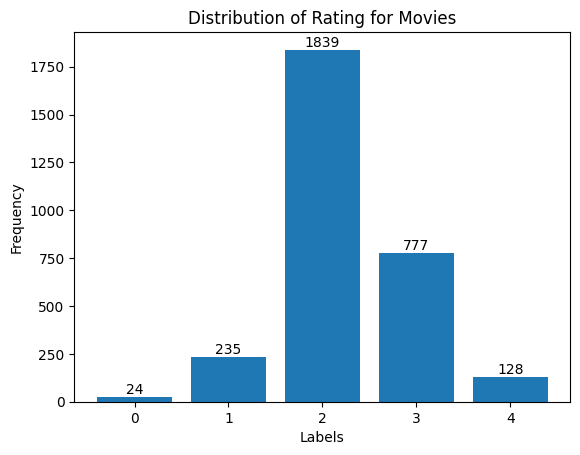

In [438]:
# Plot bar plot of y
counts = np.bincount(y)
plt.bar(range(len(counts)), counts)
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Distribution of Rating for Movies')

# Annotate each bar with its count
for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()

## Min, Max, Average, Variance

In [439]:
print("Minimum of Ratings:", round(min(y),2))
print("Maximum of Ratings:", round(max(y),2))
print("Average of Ratings:", round(np.mean(y),2))
print("Variance of Ratings:",round(np.var(y),2))

Minimum of Ratings: 0
Maximum of Ratings: 4
Average of Ratings: 2.25
Variance of Ratings: 0.48


## Pair Plot

In [ ]:
# Create a pairplot
pairplot = sns.pairplot(X_train, hue='imdb_score', diag_kind='kde')

# save image
pairplot.savefig('pairplot.png')

## K-NN 

In [441]:
# Feature selection 
feature_selection = SelectKBest(score_func=f_classif, k=10)

# Define the pipeline with preprocessing, feature selection, and KNN classifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', feature_selection),
    ('knn', KNeighborsClassifier(weights='distance'))
])

# Define parameter grid
param_grid = {
    'knn__n_neighbors': range(30,40),  
    'knn__metric': ['euclidean', 'manhattan'],
}

# Perform grid search with cross-validation
knn_grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=2)
knn_grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END .........knn__metric=euclidean, knn__n_neighbors=30; total time=   0.0s
[CV] END .........knn__metric=euclidean, knn__n_neighbors=30; total time=   0.0s
[CV] END .........knn__metric=euclidean, knn__n_neighbors=30; total time=   0.0s
[CV] END .........knn__metric=euclidean, knn__n_neighbors=30; total time=   0.0s
[CV] END .........knn__metric=euclidean, knn__n_neighbors=30; total time=   0.0s
[CV] END .........knn__metric=euclidean, knn__n_neighbors=31; total time=   0.0s
[CV] END .........knn__metric=euclidean, knn__n_neighbors=31; total time=   0.0s
[CV] END .........knn__metric=euclidean, knn__n_neighbors=31; total time=   0.0s
[CV] END .........knn__metric=euclidean, knn__n_neighbors=31; total time=   0.0s
[CV] END .........knn__metric=euclidean, knn__n_neighbors=31; total time=   0.0s
[CV] END .........knn__metric=euclidean, knn__n_neighbors=32; total time=   0.0s
[CV] END .........knn__metric=euclidean, knn__n

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['num_critic_for_reviews',
                                                                          'duration',
                                                                          'director_facebook_likes',
                                                                          'actor_3_facebook_likes',
                                                                          'actor_1_facebook_likes',
                                                                          'gross',
                                                                          'num_voted_users',
                                                                          'cast_total_facebook_likes',
                                                                          'facenumber_in_poster',
                                                                          'num_user_for_reviews',
                                                                          'title_year',
                                                                          'actor_2_facebook_likes',
                                                                          'movie_facebook_likes',
                                                                          'average_degree_centrality'])])),
                                       ('feature_selection', SelectKBest()),
                                       ('knn',
                                        KNeighborsClassifier(weights='distance'))]),
             param_grid={'knn__metric': ['euclidean', 'manhattan'],
                         'knn__n_neighbors': range(30, 40)},
             scoring='accuracy', verbose=2)

In [442]:
# Get the best parameters and best score
best_params = knn_grid_search.best_params_
best_score = knn_grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Evaluate on the validation set using the best model
knn_best_model = knn_grid_search.best_estimator_

# View accuracy
val_accuracy = accuracy_score(y_val, knn_best_model.predict(X_val))
print("Validation Accuracy with Best Model:", val_accuracy)

Best Parameters: {'knn__metric': 'manhattan', 'knn__n_neighbors': 31}
Best Score: 0.6687738755391252
Validation Accuracy with Best Model: 0.6511627906976745


### Predict with KNN

In [443]:
# Make predictions on X_test with KNN
predictions = knn_best_model.predict(X_test)

# Create a DataFrame to store the predictions
prediction_df = pd.DataFrame({'id': range(1, len(predictions) + 1), 'imdb_score_binned': predictions})

# Write the predictions to a CSV file
prediction_df.to_csv('knn_predictions.csv', index=False)

## Decision Tree / Random Forest


In [462]:
# Define preprocessing steps
feature_selector = SelectKBest(score_func=f_classif, k=10)  
classifier = RandomForestClassifier(n_estimators=100, 
                                    max_features='sqrt',
                                    bootstrap=True,
                                    class_weight='balanced',
                                    max_depth=None)

# Define the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selector', feature_selector),
    ('classifier', classifier)
])

# Define parameter grid
param_grid = {
    'classifier__min_samples_split': [2, 5],
}

# Perform grid search with cross-validation
rf_grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring='accuracy', verbose=2)
rf_grid_search.fit(X_train, y_train)


Fitting 10 folds for each of 2 candidates, totalling 20 fits
[CV] END ....................classifier__min_samples_split=2; total time=   0.6s
[CV] END ....................classifier__min_samples_split=2; total time=   0.6s
[CV] END ....................classifier__min_samples_split=2; total time=   0.5s
[CV] END ....................classifier__min_samples_split=2; total time=   0.5s
[CV] END ....................classifier__min_samples_split=2; total time=   0.5s
[CV] END ....................classifier__min_samples_split=2; total time=   0.5s
[CV] END ....................classifier__min_samples_split=2; total time=   0.5s
[CV] END ....................classifier__min_samples_split=2; total time=   0.6s
[CV] END ....................classifier__min_samples_split=2; total time=   0.5s
[CV] END ....................classifier__min_samples_split=2; total time=   0.6s
[CV] END ....................classifier__min_samples_split=5; total time=   0.5s
[CV] END ....................classifier__min_sam

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['num_critic_for_reviews',
                                                                          'duration',
                                                                          'director_facebook_likes',
                                                                          'actor_3_facebook_likes',
                                                                          'actor_1_facebook_likes',
                                                                          'gross',
                                                                          'num_voted_users',
                                                                          'cast_total_facebook_likes',
                                                                          'facenumber_in_poster',
                                                                          'num_user_for_reviews',
                                                                          'title_year',
                                                                          'actor_2_facebook_likes',
                                                                          'movie_facebook_likes',
                                                                          'average_degree_centrality'])])),
                                       ('feature_selector', SelectKBest()),
                                       ('classifier',
                                        RandomForestClassifier(class_weight='balanced'))]),
             param_grid={'classifier__min_samples_split': [2, 5]},
             scoring='accuracy', verbose=2)

In [486]:
# Get the best parameters and best score
best_params = rf_grid_search.best_params_
best_score = rf_grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Evaluate on the validation set using the best model
rf_best_model = rf_grid_search.best_estimator_
val_accuracy = rf_best_model.score(X_val, y_val)
print("Validation Accuracy with Best Model:", val_accuracy)

Best Parameters: {'classifier__min_samples_split': 5}
Best Score: 0.7268703020363537
Validation Accuracy with Best Model: 0.7109634551495017


## Predict with Random Forest

In [487]:
# Make predictions on X_test with Random Forest
predictions = rf_best_model.predict(X_test)

# Create a DataFrame to store the predictions
prediction_df = pd.DataFrame({'id': range(1, len(predictions) + 1), 'imdb_score_binned': predictions})

# Write the predictions to a CSV file
prediction_df.to_csv('rf_predictions.csv', index=False)

## SVM


In [451]:
# Define feature selection, imputation, and SVM classifier
feature_selector = SelectKBest(score_func=f_classif, k=14)  
classifier = SVC(gamma='scale')

# Define the pipeline including feature engineering
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selector', feature_selector),
    ('classifier', classifier)
])

# Define parameter grid
param_grid = {
    'classifier__C': range(3,5)
}

# Perform grid search with cross-validation
svm_grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring='accuracy', verbose=2)   # Verbose shows comments during search
svm_grid_search.fit(X_train, y_train)


Fitting 10 folds for each of 2 candidates, totalling 20 fits
[CV] END ....................................classifier__C=3; total time=   0.2s
[CV] END ....................................classifier__C=3; total time=   0.1s
[CV] END ....................................classifier__C=3; total time=   0.2s
[CV] END ....................................classifier__C=3; total time=   0.1s
[CV] END ....................................classifier__C=3; total time=   0.1s
[CV] END ....................................classifier__C=3; total time=   0.2s
[CV] END ....................................classifier__C=3; total time=   0.1s
[CV] END ....................................classifier__C=3; total time=   0.2s
[CV] END ....................................classifier__C=3; total time=   0.2s
[CV] END ....................................classifier__C=3; total time=   0.2s
[CV] END ....................................classifier__C=4; total time=   0.2s
[CV] END ....................................cla

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['num_critic_for_reviews',
                                                                          'duration',
                                                                          'director_facebook_likes',
                                                                          'actor_3_facebook_likes',
                                                                          'actor_1_facebook_likes',
                                                                          'gross',
                                                                          'num_voted_users',
                                                                          'cast_total_facebook_likes',
                                                                          'facenumber_in_poster',
                                                                          'num_user_for_reviews',
                                                                          'title_year',
                                                                          'actor_2_facebook_likes',
                                                                          'movie_facebook_likes',
                                                                          'average_degree_centrality'])])),
                                       ('feature_selector', SelectKBest(k=14)),
                                       ('classifier', SVC())]),
             param_grid={'classifier__C': range(3, 5)}, scoring='accuracy',
             verbose=2)

In [452]:
# Get the best parameters and best score
best_params = svm_grid_search.best_params_
best_score = svm_grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Evaluate on the validation set using the best model
svm_best_model = svm_grid_search.best_estimator_
val_accuracy = svm_best_model.score(X_val, y_val)
print("Validation Accuracy with Best Model:", val_accuracy)
print("Classification Report:", classification_report(y_val, svm_best_model.predict(X_val), zero_division=1))


Best Parameters: {'classifier__C': 4}
Best Score: 0.6980060133934674
Validation Accuracy with Best Model: 0.7009966777408638
Classification Report:               precision    recall  f1-score   support

           0       1.00      0.00      0.00         3
           1       1.00      0.00      0.00        23
           2       0.70      0.96      0.81       183
           3       0.70      0.37      0.48        81
           4       0.75      0.55      0.63        11

    accuracy                           0.70       301
   macro avg       0.83      0.37      0.38       301
weighted avg       0.73      0.70      0.64       301



### Predict with SVM

In [478]:
# Make predictions on X_test with SVM
predictions = svm_best_model.predict(X_test)

# Create a DataFrame to store the predictions
prediction_df = pd.DataFrame({'id': range(1, len(predictions) + 1), 'imdb_score_binned': predictions})

# Write the predictions to a CSV file
prediction_df.to_csv('svm_predictions.csv', index=False)

## SVM Bagging

In [466]:
# BOOTSTRAPPING
# Define the number of bootstrap iterations
n_bootstrap = 50

# Initialize a list to store predictions
bagged_predictions = []

# Perform bootstrap resampling and bagging
for _ in tqdm(range(n_bootstrap), desc='Bootstrapping'):
    # Generate a bootstrap sample (with replacement)
    bootstrap_indices = np.random.choice(len(X_train), size=len(X_train), replace=True)
    X_bootstrap = X_train.iloc[bootstrap_indices]
    y_bootstrap = y_train.iloc[bootstrap_indices]

    # Fit on the bootstrap sample
    svm_grid_search.best_estimator_.fit(X_bootstrap, y_bootstrap)
    
    # Make predictions on X_test with the fitted SVM classifier
    predictions = svm_grid_search.best_estimator_.predict(X_test)
    bagged_predictions.append(predictions)

# Aggregate predictions using majority voting
voting_predictions = []
for i in range(len(X_test)):
    predictions = [bagged_pred[i] for bagged_pred in bagged_predictions]
    majority_prediction = max(set(predictions), key=predictions.count)
    voting_predictions.append(majority_prediction)


Bootstrapping: 100%|██████████| 50/50 [00:17<00:00,  2.79it/s]


In [467]:
# Output predictions to a CSV file
output_df = pd.DataFrame({'id': range(1, len(voting_predictions) + 1), 'imdb_score_binned': voting_predictions})
output_df.to_csv('svm-bagging_predictions.csv', index=False)

## Permutation Feature Importance

In [468]:
# Fit your SVM model (best_model) on the training data
svm_best_model.fit(X_train, y_train)

# Compute baseline performance on the validation set
baseline_score = svm_best_model.score(X_val, y_val)

# Compute permutation feature importance
perm_importance = permutation_importance(svm_best_model, X_val, y_val, n_repeats=10, random_state=42)

# Get feature importances and their names
feature_importances = perm_importance.importances_mean
feature_names = X_val.columns


['num_voted_users', 'title_year', 'gross', 'num_critic_for_reviews', 'duration', 'movie_facebook_likes', 'num_user_for_reviews', 'director_facebook_likes', 'facenumber_in_poster', 'actor_3_facebook_likes']


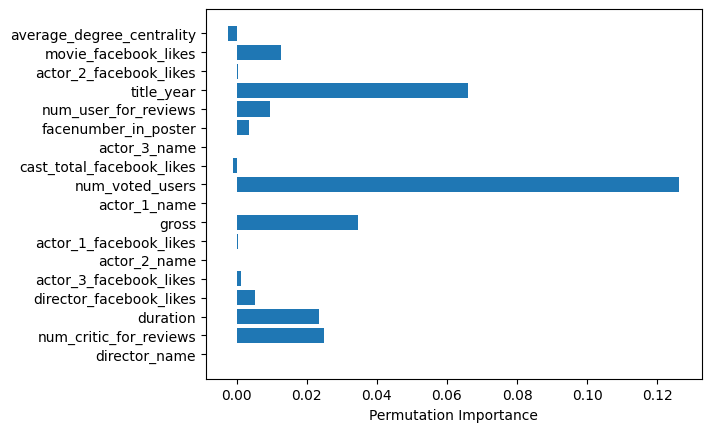

In [469]:

features = zip(feature_names, feature_importances)
sorted_features = sorted(features, key=lambda x: x[1], reverse=True)

# Get the top 10 features
top_10_features = sorted_features[:10]
top_10_feature_names = [feat_name for feat_name, feat_imp in top_10_features]
print(top_10_feature_names)

# Plot feature importance
plt.barh(feature_names, feature_importances)
plt.xlabel('Permutation Importance')
plt.show()


## Logistic Regression


In [479]:
# Define feature selection and logistic regression classifier
feature_selector = SelectKBest(score_func=f_classif, k=10)
classifier = LogisticRegression(max_iter=1000)  

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selector', feature_selector),
    ('classifier', classifier)
])

# Define parameter grid
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100] 
}

# Perform grid search with cross-validation
logistic_grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring='accuracy', verbose=2)
logistic_grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] END .................................classifier__C=0.01; total time=   0.0s
[CV] END .................................classifier__C=0.01; total time=   0.0s
[CV] END .................................classifier__C=0.01; total time=   0.0s
[CV] END .................................classifier__C=0.01; total time=   0.0s
[CV] END .................................classifier__C=0.01; total time=   0.0s
[CV] END .................................classifier__C=0.01; total time=   0.0s
[CV] END .................................classifier__C=0.01; total time=   0.0s
[CV] END .................................classifier__C=0.01; total time=   0.0s
[CV] END .................................classifier__C=0.01; total time=   0.0s
[CV] END .................................classifier__C=0.01; total time=   0.0s
[CV] END ..................................classifier__C=0.1; total time=   0.0s
[CV] END ..................................class

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['num_critic_for_reviews',
                                                                          'duration',
                                                                          'director_facebook_likes',
                                                                          'actor_3_facebook_likes',
                                                                          'actor_1_facebook_likes',
                                                                          'gross',
                                                                          'num_voted_users',
                                                                          'cast_total_facebook_likes',
                                                                          'facenumber_in_poster',
                                                                          'num_user_for_reviews',
                                                                          'title_year',
                                                                          'actor_2_facebook_likes',
                                                                          'movie_facebook_likes',
                                                                          'average_degree_centrality'])])),
                                       ('feature_selector', SelectKBest()),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'classifier__C': [0.01, 0.1, 1, 10, 100]},
             scoring='accuracy', verbose=2)

In [480]:
# Get the best model from the grid search
reg_best_model = logistic_grid_search.best_estimator_

# Predictions on validation set
y_pred_val = reg_best_model.predict(X_val)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred_val)
print("Accuracy:", accuracy)

# Classification report
print("Classification Report:")
print(classification_report(y_val, y_pred_val, zero_division=1))

Accuracy: 0.6976744186046512
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00         3
           1       0.00      0.00      0.00        23
           2       0.70      0.93      0.80       183
           3       0.69      0.38      0.49        81
           4       0.80      0.73      0.76        11

    accuracy                           0.70       301
   macro avg       0.64      0.41      0.41       301
weighted avg       0.65      0.70      0.65       301



# Further implement
## Ensemble Method
Stacking or Voting Classifier / Feature engineering / Data processing / Hyperparameter Tuning / Different cross-val

In [481]:
# Define the ensemble model                  
voting_clf = Pipeline([
    ('voting', VotingClassifier(estimators=[
        ('knn', knn_best_model),
        ('reg', reg_best_model),        
        ('rf', rf_best_model),
        ('svm', svm_best_model),
    ], voting='hard', weights = [1, 1, 3, 1]))                   
])

voting_clf.fit(X_train, y_train)

voting_pred = voting_clf.predict(X_val)

# Evaluate the voting classifier
voting_accuracy = accuracy_score(y_val, voting_pred)
print("Voting Classifier Accuracy:", voting_accuracy)
print("Classification Report:", classification_report(y_val, voting_clf.predict(X_val), zero_division=1))

Voting Classifier Accuracy: 0.6943521594684385
Classification Report:               precision    recall  f1-score   support

           0       1.00      0.00      0.00         3
           1       0.67      0.09      0.15        23
           2       0.70      0.94      0.80       183
           3       0.67      0.36      0.47        81
           4       0.67      0.55      0.60        11

    accuracy                           0.69       301
   macro avg       0.74      0.39      0.40       301
weighted avg       0.69      0.69      0.65       301



In [482]:
ensemble_predictions = voting_clf.predict(X_test)

# Create a DataFrame to store the predictions
prediction_df = pd.DataFrame({'id': range(1, len(predictions) + 1), 'imdb_score_binned': ensemble_predictions})

# Write the predictions to a CSV file
prediction_df.to_csv('ensemble_predictions.csv', index=False)

### Compare csv's for different predictions


In [485]:
csv1 = 'rf_predictions.csv'
csv2 = 'svm_predictions.csv'

df1_name = csv1.split('_')[0]
df2_name = csv2.split('_')[0]

# Read the first CSV file
df1 = pd.read_csv(csv1)

# Read the second CSV file
df2 = pd.read_csv(csv2)

# Compare the two DataFrames
differences = df1.compare(df2)
differences = differences.rename(columns={'self': df1_name, 'other': df2_name})

# Print the differences
print("Differences between", csv1, "and", csv2, "with movie titles:")
print("Number of differences:", len(differences))

movie_titles = pd.read_csv("project_data/test_dataset.csv").loc[differences.index, 'movie_title']
differences['movie'] = movie_titles

# Join movie titles to differences DataFrame
display(differences)



Differences between rf_predictions.csv and svm_predictions.csv with movie titles:
Number of differences: 115


imdb_score_binned                                  movie
                   rf  svm                                  
3                 3.0  2.0                Road to Perdition 
5                 3.0  2.0                        Blindness 
7                 3.0  2.0                   A Few Good Men 
34                3.0  2.0                     Fright Night 
42                3.0  2.0      Love in the Time of Cholera 
..                ...  ...                               ...
701               3.0  2.0                  Central Station 
707               2.0  3.0              Conan the Barbarian 
714               3.0  2.0                            Shame 
747               3.0  2.0                         Rushmore 
748               2.0  3.0  Abraham Lincoln: Vampire Hunter 

[115 rows x 3 columns]

## View top models from grid search

In [ ]:
def viewTopModels(results, num):
    # Sort the results by mean_test_score in descending order to find the top-performing models
    top_models = results.sort_values(by='mean_test_score', ascending=False).head(num)

    # Print the top models along with their parameters and scores
    print(f"Top {num} Models:")
    top_models[['params', 'mean_test_score']].to_csv("top_models.csv", index=False)
